# Notebook to replicate the analysis proposed in the Section Data of the paper

In [1]:
import sys

import numpy as np
import pandas as pd 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import random
sys.path.append("..")
import hypergraphx
from hypergraphx import Hypergraph
from hypergraphx.readwrite import load_hypergraph, save_hypergraph

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Fix visualization settings
params = {'figure.figsize': (7,6),
          'font.family': 'serif', 
          'axes.labelsize': '29',
          'axes.titlesize':'29',
          'xtick.labelsize':'23',
          'ytick.labelsize':'23',
          'legend.fontsize': '20',
          'hatch.color': 'white'}
plt.rcParams.update(params)

SIZE_TWO_COLOR = 'darkgrey'
SIZE_THREE_COLOR = '#FFBC79'
SIZE_FOUR_COLOR = '#79BCFF'
hye_facecolor = {SIZE_TWO_COLOR: 'black', SIZE_THREE_COLOR: "#C85200", SIZE_FOUR_COLOR: "#006BA4"}

### Input data

In [3]:
H = load_hypergraph("../test_data/hs/hs.json")
print(H)

Hypergraph with 327 nodes and 7818 edges.
Distribution of hyperedge sizes: {2: 5498, 3: 2091, 4: 222, 5: 7}


### A) Higher-order degree distributions for different orders

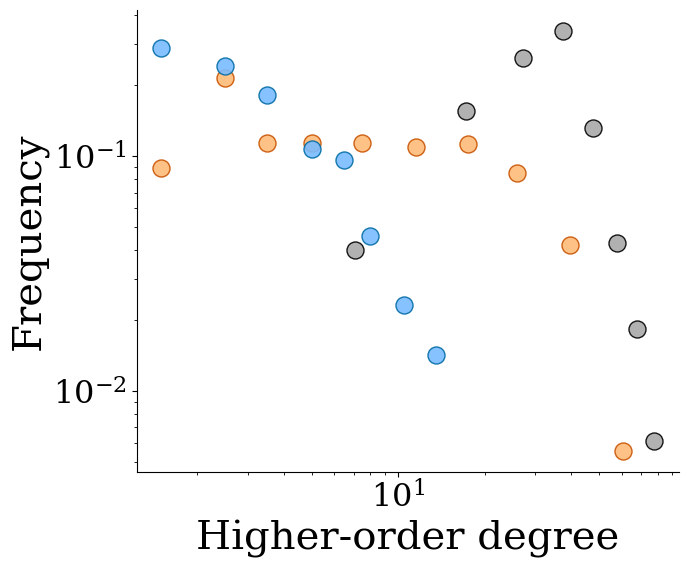

In [4]:
def distr_bin(data, n_bin=30, logbin=True):
    ###This is a very old function copied from my c++ library. It's ugly but works :)
    """ Logarithmic binning of raw positive data;
        Input:
            data = np array,
            bins= number if bins,
            logbin = if true log bin
        Output (array: bins, array: hist) 
        bins: centred bins 
        hist: histogram value / (bin_length*num_el_data) [nonzero]
    """
    if len(data)==0:
        print( "Error empty data\n")
    min_d = float(min(data))
    if logbin and min_d<=0:
        print ("Error nonpositive data\n")
    n_bin = float(n_bin)            #ensure float values
    bins = np.arange(n_bin+1)
    if logbin:
        data = np.array(data)/min_d
        base= np.power(float(max(data)) , 1.0/n_bin)
        bins = np.power(base,bins)
        bins = np.ceil(bins)                   #to avoid problem for small ints
    else:
        data = np.array(data) + min_d          #to include negative data
        delta = (float(max(data)) - float(min(data)))/n_bin
        bins = bins*delta + float(min(data))
    n_bin = int(n_bin)
    #print ('first bin: ', bins[0], 'first data:', min(data), 'max bin:', bins[n_bin], 'max data', float(max(data)))
    hist = np.histogram(data, bins)[0]
    ii = np.nonzero(hist)[0]            #take non zero values of histogram
    bins = bins[ii]
    hist = hist[ii]
    bins=np.append(bins,float(max(data)))          #append the last bin
    bin_len = np.diff(bins)
    bins =  bins[:-1] + bin_len/2.0     #don't return last bin, centred boxes
    if logbin:
        hist = hist/bin_len                 #normalize values
        bins = bins*min_d                   #restore original bin values
    else:
        bins = bins - min_d 
    res = list(zip(bins, hist/float(sum(hist))))    #restore original bin values, norm hist
    return list(zip(*res))

#fig, ax = plt.subplots(figsize = (8, 4))
# write three color pastel in a color dict
color_dict = {2: SIZE_TWO_COLOR, 3:SIZE_THREE_COLOR, 4:SIZE_FOUR_COLOR}

for size in [2,3,4]:
    if size == 2:
        logbin = False
    else:
        logbin = True
    degrees = list(H.degree_sequence(size=size).values())
    degrees = [d for d in degrees if d > 0]
    #print(degrees)
    if size == 2:
        n_bin = 8
    else:
        n_bin = 10
    bins, frequency =distr_bin(degrees, n_bin=n_bin, logbin=logbin)
    # print(bins)
    # print(frequency)
    # output of scatter in svg
    plt.scatter(bins, frequency, alpha = .9, label="Size: {}".format(size), s = 150, c = color_dict[size],
               edgecolors=hye_facecolor[color_dict[size]])
#plt.legend(frameon=False, loc = 'lower left', handletextpad =-.2 )
# font size
#plt.rcParams.update({'font.size': 20})
# font serif
#plt.rcParams['font.family'] = 'serif'
# make the dots in the legen closer to the text

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Higher-order degree")
plt.ylabel("Frequency")
sns.despine()


### B) Motifs 

In [5]:
from hypergraphx.motifs.motifs import compute_motifs

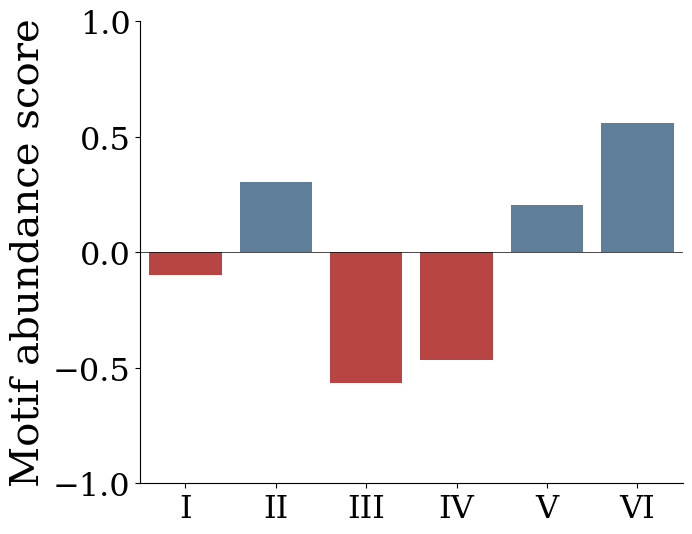

In [6]:
motifs3 = [-0.09743189457908542, 0.3057352878609137, -0.5664795273602301, -0.46704869712770475, 0.20599282046932665, 0.5617529503113179]

# Plot a bar chart of the motif counts
cols = ['#cd3031' if (x < 0) else '#557fa3' for x in motifs3]
g = sns.barplot(x=["I", "II", "III", "IV", "V", "VI"], y=motifs3, palette=cols)
g.axhline(0, color="black", linewidth=0.5)
plt.ylim(-1, 1)
plt.ylabel("Motif abundance score")
sns.despine()

### C) Communities 

In [7]:
from hypergraphx.utils import normalize_array, calculate_permutation_matrix
from hypergraphx.communities.hypergraph_mt.model import HypergraphMT
from hypergraphx.viz import draw_communities

from hypergraphx.filters.metadata_filters import filter_hypergraph

In [8]:
# For visualization purposes we analyse only 3 classes ['PC', 'PC*', 'PSI*']
H_filtered = load_hypergraph("../test_data/hs/hs.json")
filter_hypergraph(H_filtered, node_criteria = {'class': ['PC', 'PC*', 'PSI*']})

In [9]:
# Fix setting
K = 3  # number of communities
seed = 20  # random seed
n_realizations = 10  # number of realizations with different random initialization
max_iter = 500  # maximum number of EM iteration steps before aborting
check_convergence_every = 1 # number of steps in between every convergence check
normalizeU = False  # if True, then the membership matrix u is normalized such that every row sums to 1
baseline_r0 = False  # if True, then for the first iteration u is initialized around the solution of the Hypergraph Spectral Clustering
verbose = False  # flag to print details

In [10]:
# Model training
model = HypergraphMT(n_realizations=n_realizations, 
                     max_iter=max_iter, 
                     check_convergence_every=check_convergence_every, 
                     verbose=verbose
                    )

u, _, _ = model.fit(H_filtered, 
                    K=K, 
                    seed=seed, 
                    normalizeU=normalizeU, 
                    baseline_r0=baseline_r0
                   )

In [11]:
# Normalize membership matrix by row
u = normalize_array(u, axis=1)

Text(0.5, 1.0, 'Higher-order communities')

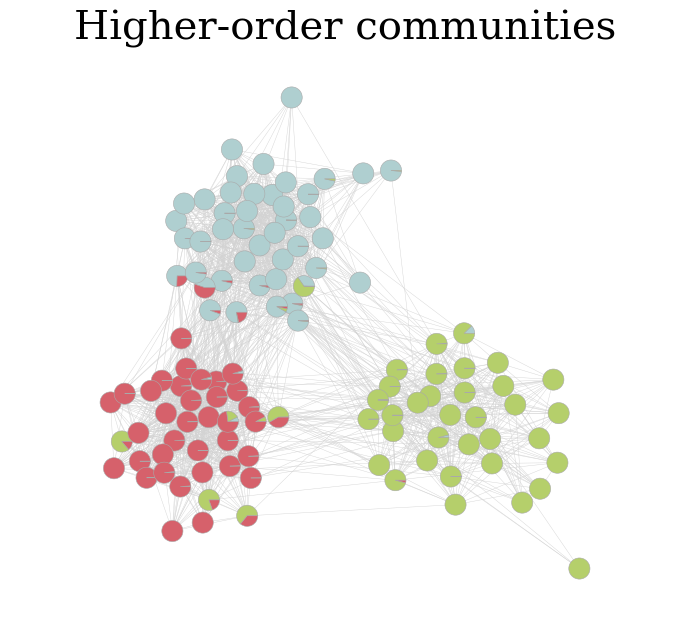

In [12]:
# Visualize with a network and pie charts
col = {0:'#AFCFD0', 1: '#b5cf6b', 2: '#d6616b'}

plt.subplot(1,1,1)
ax=plt.gca()
draw_communities(hypergraph=H_filtered, u=u, col=col, node_size=0.03, ax=ax, with_node_labels=False, 
                 scale=0.8, opt_dist=1, wedge_width=0.4, threshold_group=0., wedge_color='darkgray')
sns.despine()
plt.title("Higher-order communities")
#plt.savefig("figures/communities.svg", bbox_inches="tight")

### D) Statistics of the filtered systems after applying SVH

In [13]:
from hypergraphx.filters import get_svh

In [14]:
validated = get_svh(H, mp=True)

In [18]:
import pandas as pd

df_list = []

for size in validated:
    if size < 5:
        data = validated[size]
        print(f"Processing size {size}")
        
        # Check if data is empty
        total_count = data.shape[0]
        if total_count == 0:
            print(f"No data for size {size}")
            continue
        
        # Create DataFrame for total interactions
        df_total = pd.DataFrame({
            'size': [size] * total_count,
            'fdr': ['Total interactions'] * total_count
        })
        df_list.append(df_total)
        
        if 'fdr' in data.columns and data['fdr'].dtype == bool:
            # Filter data where 'fdr' is True
            filtered_data = data[data['fdr']]
            filtered_count = filtered_data.shape[0]
            print(f"Filtered interactions count: {filtered_count}")
            
            if filtered_count > 0:
                # Create DataFrame for filtered interactions
                df_filtered = pd.DataFrame({
                    'size': [size] * filtered_count,
                    'fdr': ['Filtered interactions'] * filtered_count
                })
                df_list.append(df_filtered)
            else:
                print(f"No filtered interactions for size {size}")
        else:
            print(f"'fdr' column missing or not boolean in data for size {size}")

if df_list:
    df = pd.concat(df_list, ignore_index=True)
else:
    df = pd.DataFrame(columns=['size', 'fdr'])


Processing size 2
Filtered interactions count: 1217
Processing size 3
Filtered interactions count: 518
Processing size 4
Filtered interactions count: 62


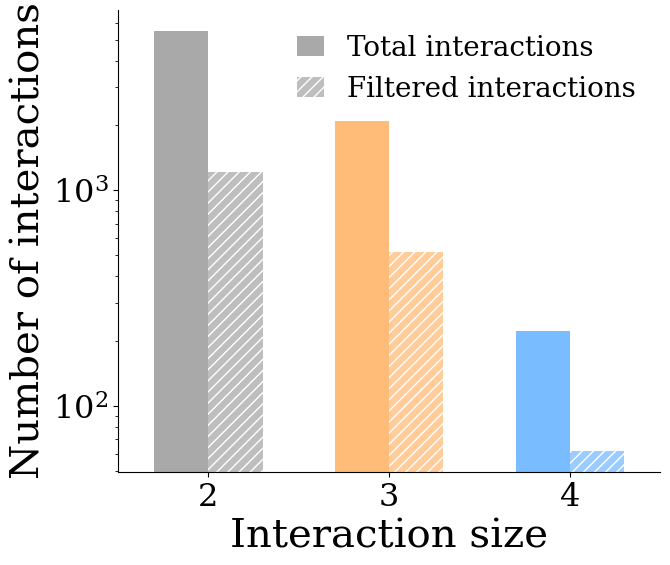

In [19]:
g = sns.countplot(data=df, x="size", hue="fdr", width=0.6)

count = 0
g.patches[0].set_facecolor(SIZE_TWO_COLOR)
g.patches[1].set_facecolor(SIZE_THREE_COLOR)
g.patches[2].set_facecolor(SIZE_FOUR_COLOR)
g.patches[3].set_facecolor(SIZE_TWO_COLOR)
g.patches[3].set_alpha(0.75)
g.patches[3].set_hatch('///')
g.patches[4].set_facecolor(SIZE_THREE_COLOR)
g.patches[4].set_alpha(0.75)
g.patches[4].set_hatch('///')
g.patches[5].set_facecolor(SIZE_FOUR_COLOR)
g.patches[5].set_alpha(0.75)
g.patches[5].set_hatch('///')

plt.ylabel("Number of interactions")
plt.yscale("log")
plt.xlabel("Interaction size")
sns.despine()
plt.legend(loc='upper right', frameon=False, handlelength=1)
#plt.savefig("figures/svh.svg", bbox_inches="tight")

### E) Ability of the sampling method to reproduce one measure 

In [20]:
from hypergraphx.communities.hy_mmsbm.model import HyMMSBM
from hypergraphx.generation.hy_mmsbm_sampling import HyMMSBMSampler
from hypergraphx.measures.sub_hypergraph_centrality import subhypergraph_centrality

In [21]:
SEED = 112233
np.random.seed(SEED)
random.seed(SEED)

# First, infer generative parameters utilizing Hy-MMSBM.
model = HyMMSBM(K=9, assortative=True)
model.fit(H, n_iter=100)

# Sample based on these
sampler = HyMMSBMSampler(
    u = model.u,
    w = model.w,
    max_hye_size = None,
    exact_dyadic_sampling = True,
    burn_in_steps = 1000,
    intermediate_steps = 1000,
)
samples = sampler.sample(
    deg_seq = None,
    dim_seq = None,
    avg_deg = None,
    initial_hyg = H,
    allow_rescaling = False
)
sampled_h = [next(samples) for _ in range(10)]

/Users/francesco/hgx-dev/hypergraphx/hypergraphx/generation/hy_mmsbm_sampling.py:493: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/hgx-dev/hypergraphx/hypergraphx/generation/hy_mmsbm_sampling.py:493: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/hgx-dev/hypergraphx/hypergraphx/generation/hy_mmsbm_sampling.py:493: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/hgx-dev/hypergraphx/hypergraphx/generation/hy_mmsbm_sampling.py:493: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/hgx-dev/hypergraphx/hypergraphx/generation/hy_mmsbm_sampling.py:493: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/hgx-dev/hypergraphx/hypergraphx/generation/hy_mmsbm_sampling.py:493: RuntimeWarning: overflow encountered in

In [22]:
samples_centr = [subhypergraph_centrality(h) for h in sampled_h]
original_centr = subhypergraph_centrality(H)

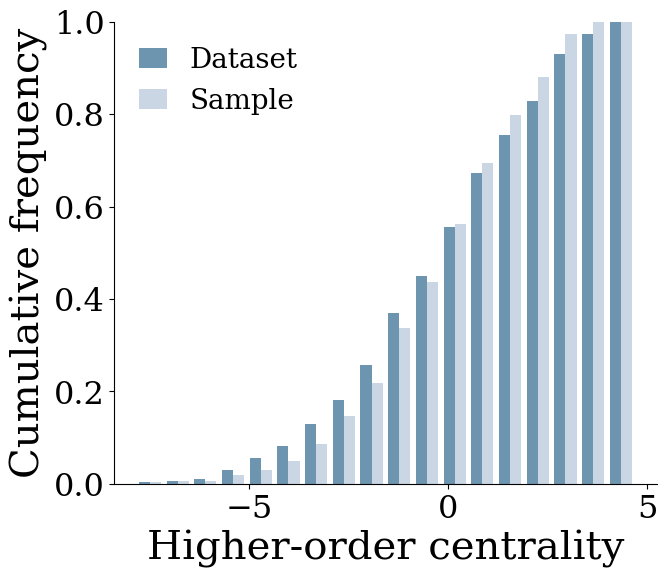

In [23]:
SAMPLE_IDX = 0
sample_centr = samples_centr[SAMPLE_IDX]


hist = plt.hist(
    [
        original_centr - np.mean(original_centr), 
        samples_centr[SAMPLE_IDX] - np.mean(samples_centr[SAMPLE_IDX])
    ],
    # label=["Dataset", "Sample"],
    cumulative=True,
    color=['#3d7296','#bac9dc'], 
    alpha=0.75,
    #rwidth=0.5, 
    bins=18, 
    density=True,
)
xmin, xmax = plt.xlim()

plt.xlim(xmin, xmax)
plt.ylabel("Cumulative frequency")
plt.xlabel("Higher-order centrality")
plt.ylim(0,1)

sns.despine()

plt.legend(frameon=False, labels=["Dataset", "Sample"], loc="upper left", handlelength=1)

### F) Temporal higher-order properties

In [29]:
correlation_by_order = np.load("./_example_data/temporal_correlations.npy")

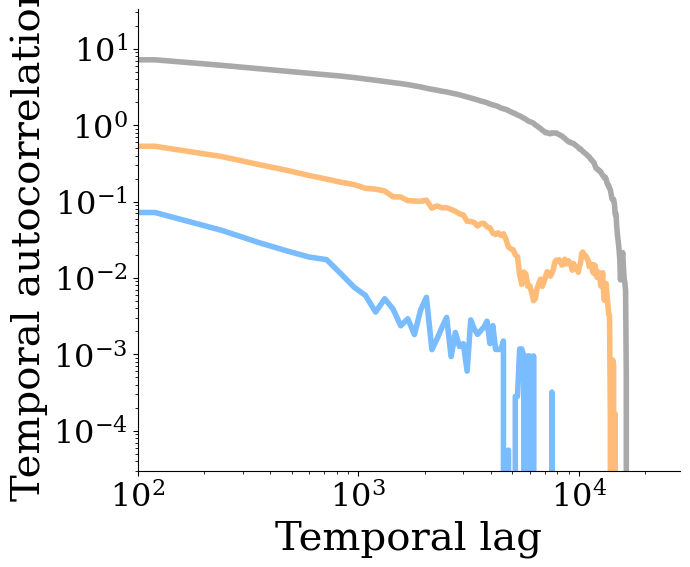

In [30]:
#fig, ax = plt.subplots(1,1,figsize=(8,6))

plt.subplot(1,1,1)
ax = plt.gca()

color_dict = {2: SIZE_TWO_COLOR, 3:SIZE_THREE_COLOR, 4:SIZE_FOUR_COLOR}
for d in range(3):
    ax.plot(range(0,1440*20,6*20),correlation_by_order[d,:], label="size = %s" % (d+2),
                color=color_dict[2+d], lw=4)

ax.set_xlabel("Temporal lag")
ax.set_ylabel("Temporal autocorrelation")
ax.tick_params(axis='both', which='major')

ax.loglog()
ax.set_xlim(left=100,right=1441*20)
sns.despine()

### G) Statistics of a higher-order spreading process run on top of it 

In [26]:
social_contagion_data = np.load("./_example_data/social_contagion.npy")

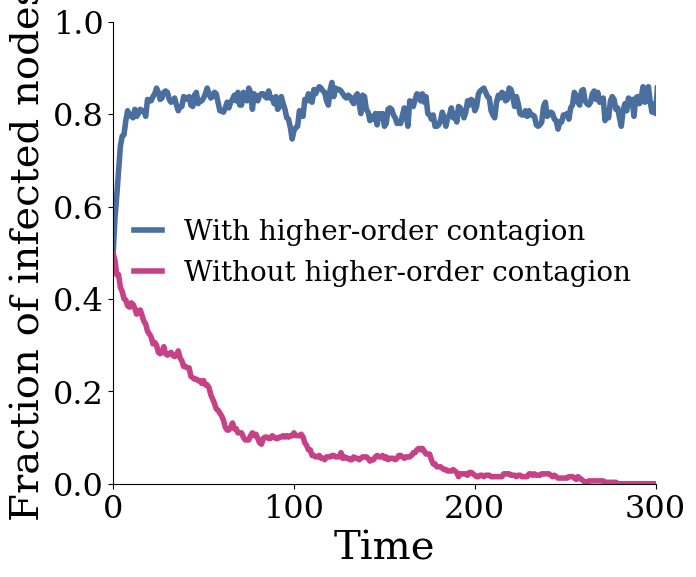

In [27]:
plt.subplot(1,1,1)
ax = plt.gca()

T = 500
ax.plot(range(T),social_contagion_data[:,0], 
        lw=4, c='#4a6e9e',
        label="With higher-order contagion")
ax.plot(range(T),social_contagion_data[:,1], 
        lw=4, c='#C74187',
        label="Without higher-order contagion")

ax.set_xlim(0,300)
ax.set_ylim(0,1)
ax.tick_params(axis='both', which='major')

ax.set_xlabel("Time")
ax.set_ylabel("Fraction of infected nodes")
ax.legend(frameon=False, loc="right", handlelength=1)
sns.despine()

### H) Visualizations 

In [28]:
from hypergraphx.readwrite.loaders import load_high_school
from hypergraphx.filters import get_svh
from hypergraphx.viz.draw_hypergraph import draw_hypergraph
from hypergraphx.representations.projections import clique_projection

ModuleNotFoundError: No module named 'hypergraphx.readwrite.loaders'

In [ ]:
H = load_high_school("../test_data/hs/hs.json", filter_by_class=['PC*'])
print(H)

Hypergraph with 39 nodes and 754 edges.
Distribution of hyperedge sizes: {2: 519, 3: 217, 4: 18}


In [ ]:
# Get validated hyperedges
hs_svh = get_svh(H, approximate_pvalue=True, mp=True)

# Filter hypergraph
e4 = hs_svh[4]
e4 = e4[e4['fdr']]
lim = e4['pvalue']
lim = list(lim)
lim = list(sorted(lim))
print(lim)
lim = lim[-1]

edges = []
lim = float(lim)

for size in hs_svh:
    for i in range(len(hs_svh[size])):
        a = float(hs_svh[size]['pvalue'][i])
        b = bool(hs_svh[size]['fdr'][i])
        if a <= lim and b:
            edges.append(hs_svh[size]['edge'][i])

print(len(edges))

H2 = Hypergraph(edges)
lcc = H2.largest_component()
H2 = H2.subhypergraph(lcc)

[3.0771767141041745e-07]
61


In [ ]:
hyperedge_color_by_order = {2: SIZE_THREE_COLOR, 3: SIZE_FOUR_COLOR}
hyeperedge_facecolor_by_order = {2: hye_facecolor[SIZE_THREE_COLOR], 3: hye_facecolor[SIZE_FOUR_COLOR]}

In [ ]:
pos = nx.spring_layout(clique_projection(H2, keep_isolated=True),
                       iterations=120, seed=17, scale=1, k=0.75)
pos[214] = [0.17580071, 0.07780574]
pos[116] = [-0.02649419,  0.14016711]
pos[923] = [-0.50259044, -0.20990672]

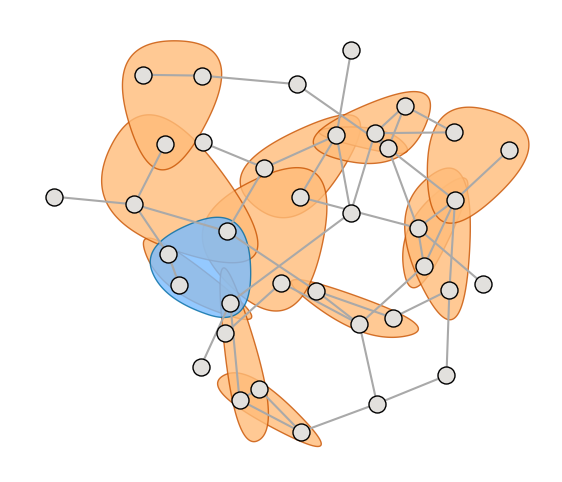

In [ ]:
plt.subplot(1,1,1)
ax=plt.gca()

draw_hypergraph(
    H2, ax=ax, pos=pos,
    edge_width=1.5, edge_color=SIZE_TWO_COLOR, hyperedge_color_by_order=hyperedge_color_by_order, 
    hyperedge_facecolor_by_order=hyeperedge_facecolor_by_order, hyperedge_alpha=0.8,
    node_size=150, node_color='#E2E0DD', node_facecolor='black', node_shape='o', with_node_labels=False
)
sns.despine()

### H) Central panel

In [ ]:
from matplotlib.patches import Patch

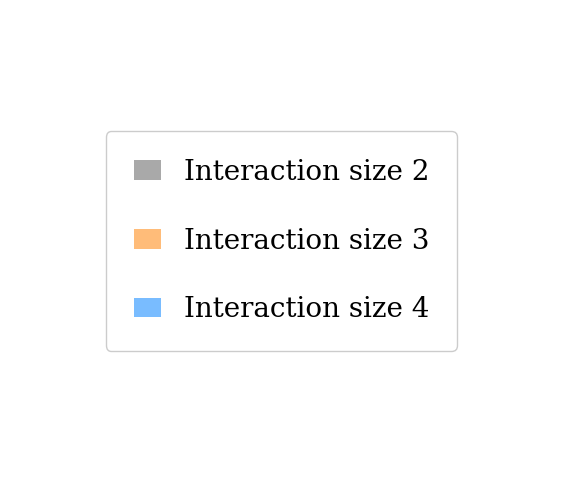

In [ ]:
plt.subplot(1,1,1)
ax = plt.gca()

color_dict = {2: SIZE_TWO_COLOR, 3:SIZE_THREE_COLOR, 4:SIZE_FOUR_COLOR}
labels = {2: 'Interaction size 2', 3: 'Interaction size 3', 4: 'Interaction size 4'}

plt.plot()

handles = [Patch(facecolor=color_dict[d], label=labels[d]) for d in color_dict.keys()]
ax.legend(handles=handles, ncol=1, loc='center', framealpha=True, handlelength=1, labelspacing=1.5, borderpad=1)
ax.axis('off')

sns.despine()
plt.savefig("figures/legend.svg", bbox_inches="tight")